# Tutorial on Safe DeepRL by Daniel and Wei

This tutorial shows how you can train modern reinforcement learning algorithms with safety constraints given by a shield. The tutorial is diveded in 5 Exercises: 
- (1) Very ligthly delve into a continuous deep reinforcement learning policy optimization algorithm: Deep Deterministic Policy Gradient (DDPG). Understand and chose parameters for accordingly.
- (2) Make it work on a classical toy example "Pendulum-v0" and obtain a good policy.
- (3) Work with a harder environment "LunarLanding" and obtain a good policy.
- (4) Work with a, yet harder environment, "SafeLunarLanding" a harder version of "LunarLanding" modified in such a way that the ship explodes if certain forces are exerted in the engines. Testing the previous model and verifying extreme negative rewards throughout learning.
- (5) Designing a shield class, which shields the agent from exploding the ship, yielding reasonable rewards throughout learning.

### Exercise (1) Deep Deterministic Policy Gradient
Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.
It is, therefore, an actor-critic method, the actor is the policy and the critic the Q-function. Look at the get_actor() and get_critic() methods, fill the parameters for the layers, and more specifically for the outputs of the functions. Make sure they make sense.

Look for blocks #change here to alter and insert your solution.

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

from exploration import OUActionNoise
from rpm import Buffer, update_target

class DDPG:
    def __init__(self,
                 problem_name,
                 num_states,
                 num_actions,
                 lower_bound,
                 upper_bound,
                 total_episodes=100):

        self.problem_name = problem_name
        self.num_states = num_states
        self.num_actions = num_actions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        self.std_dev = 0.2
        self.ou_noise = OUActionNoise(mean=np.zeros(1),
                                      std_deviation=float(self.std_dev) *
                                      np.ones(1))

        self.actor_model = self.get_actor()
        self.critic_model = self.get_critic()

        self.target_actor = self.get_actor()
        self.target_critic = self.get_critic()

        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())

        # Learning rate for actor-critic models
        self.critic_lr = 0.002
        self.actor_lr = 0.001

        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)

        self.total_episodes = total_episodes
        # Discount factor for future rewards
        self.gamma = 0.99
        # Used to update target networks
        self.tau = 0.005

        self.buffer = Buffer(50000,
                             64,
                             gamma=self.gamma,
                             num_states=self.num_states,
                             num_actions=self.num_actions)
# change here
    def get_actor(self):
        # Initialize weights between -3e-3 and 3-e3
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

        inputs = layers.Input(shape=(self.num_states, ))
        out = layers.Dense(256, activation="relu")(inputs)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(self.num_actions,
                               activation="tanh",
                               kernel_initializer=last_init)(out)

        # Our upper bound is 2.0 for Pendulum.
        outputs = outputs * self.upper_bound
        model = tf.keras.Model(inputs, outputs)
        return model
# change here


# change here
    def get_critic(self):
        # State as input
        state_input = layers.Input(shape=(self.num_states))
        state_out = layers.Dense(16, activation="relu")(state_input)
        state_out = layers.Dense(32, activation="relu")(state_out)

        # Action as input
        action_input = layers.Input(shape=(self.num_actions))
        action_out = layers.Dense(32, activation="relu")(action_input)

        # Both are passed through seperate layer before concatenating
        concat = layers.Concatenate()([state_out, action_out])

        out = layers.Dense(256, activation="relu")(concat)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(self.num_actions)(out)

        # Outputs single value for give state-action
        model = tf.keras.Model([state_input, action_input], outputs)

        return model
# change here

    def policy(self, state, noise_object):
        sampled_actions = tf.squeeze(self.actor_model(state))
        noise = noise_object()
        # Adding noise to action
        sampled_actions = sampled_actions.numpy() + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, self.lower_bound,
                               self.upper_bound)

        return [np.squeeze(legal_action)]

    def save_parameters(self):

        # Save the weights
        actor_model.save_weights("pendulum_actor.h5")
        critic_model.save_weights("pendulum_critic.h5")

        target_actor.save_weights("pendulum_target_actor.h5")
        target_critic.save_weights("pendulum_target_critic.h5")

    def load_parameters(self):

        # Save the weights
        actor_model.load_parameters("pendulum_actor.h5")
        critic_model.load_parameters("pendulum_critic.h5")

        target_actor.load_parameters("pendulum_target_actor.h5")
        target_critic.load_parameters("pendulum_target_critic.h5")


### Exercise (2) Pendulum-v0

The classsic Pendulum-v0 environment is often used to benchmark deep reinforcement learning algorithms. The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. For more information visit https://github.com/openai/gym/wiki/Pendulum-v0

In this Exercise, you will fine tune the paramters also changed above to verify the robustness of your model. An average reward higher of -200 is desirable. You do not need to change parameters in this exercise, make sure you at least understand what the method loop_env() is doing.

In [2]:
    problem = "Pendulum-v0"
    env = gym.make(problem)

    num_states = env.observation_space.shape[0]
    print("Size of State Space ->  {}".format(num_states))
    num_actions = env.action_space.shape[0]
    print("Size of Action Space ->  {}".format(num_actions))

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]

    print("Max Value of Action ->  {}".format(upper_bound))
    print("Min Value of Action ->  {}".format(lower_bound))


Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [3]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

In [3]:
    def loop_env():
        import matplotlib.pyplot as plt
        %matplotlib inline
        # from pyvirtualdisplay import Display
        # display = Display(visible=0, size=(1400, 900))
        # display.start()

        # is_ipython = 'inline' in plt.get_backend()
        # if is_ipython:
        #     from IPython import display

        # plt.ion()

        
        # To store reward history of each episode
        ep_reward_list = []
        # To store average reward history of last few episodes
        avg_reward_list = []
        # Takes about 4 min to train
        for ep in range(ddpg_agent.total_episodes):

            prev_state = env.reset()
            episodic_reward = 0
            render_episodes = 100
            # render = not (ep % render_episodes)
            render=False

            # if ddpg_agent.problem_name != 'Pendulum-v0':
            #     img = plt.imshow(env.render(mode='rgb_array'))
            while True:
                # Uncomment this to see the Actor in action
                # But not in a python notebook.
                # env.render()
                if render and ddpg_agent.problem_name != 'Pendulum-v0': 
                    img.set_data(env.render(mode='rgb_array')) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    action = env.action_space.sample()
                    env.step(action)

                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
                action = ddpg_agent.policy(tf_prev_state, ddpg_agent.ou_noise)
                # Recieve state and reward from environment.
                if ddpg_agent.num_actions>1:
                    action = action[0]
                else:
                    pass
                state, reward, done, info = env.step(action)


                ddpg_agent.buffer.record((prev_state, action, reward, state))
                episodic_reward += reward

                ddpg_agent.buffer.learn(ddpg_agent.target_actor,
                                        ddpg_agent.target_critic,
                                        ddpg_agent.actor_model,
                                        ddpg_agent.critic_model,
                                        ddpg_agent.actor_optimizer,
                                        ddpg_agent.critic_optimizer)

                update_target(ddpg_agent.target_actor.variables,
                            ddpg_agent.actor_model.variables, ddpg_agent.tau)
                update_target(ddpg_agent.target_critic.variables,
                            ddpg_agent.critic_model.variables, ddpg_agent.tau)

                # End this episode when `done` is True
                if done:
                    break

                prev_state = state

            ep_reward_list.append(episodic_reward)

            # Mean of last 40 episodes
            avg_reward = np.mean(ep_reward_list[-40:])
            print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
            avg_reward_list.append(avg_reward)

        # Plotting graph
        # Episodes versus Avg. Rewards
        plt.plot(avg_reward_list)
        plt.xlabel("Episode")
        plt.ylabel("Avg. Epsiodic Reward")
        plt.show()

Episode * 0 * Avg Reward is ==> -1858.9400611662734
Episode * 1 * Avg Reward is ==> -1566.104676881022
Episode * 2 * Avg Reward is ==> -1396.2537196305818
Episode * 3 * Avg Reward is ==> -1334.2647308767864
Episode * 4 * Avg Reward is ==> -1300.7691724501274
Episode * 5 * Avg Reward is ==> -1280.377031204149
Episode * 6 * Avg Reward is ==> -1323.03351265052
Episode * 7 * Avg Reward is ==> -1337.836077072825
Episode * 8 * Avg Reward is ==> -1339.9591000764735
Episode * 9 * Avg Reward is ==> -1321.21132643187
Episode * 10 * Avg Reward is ==> -1320.751220712427
Episode * 11 * Avg Reward is ==> -1285.9223511821049
Episode * 12 * Avg Reward is ==> -1235.1484704600987
Episode * 13 * Avg Reward is ==> -1210.6042557419062
Episode * 14 * Avg Reward is ==> -1187.4620671106104
Episode * 15 * Avg Reward is ==> -1165.0542339719739
Episode * 16 * Avg Reward is ==> -1154.6169015563441
Episode * 17 * Avg Reward is ==> -1139.607436589124
Episode * 18 * Avg Reward is ==> -1141.1400262045165
Episode * 19

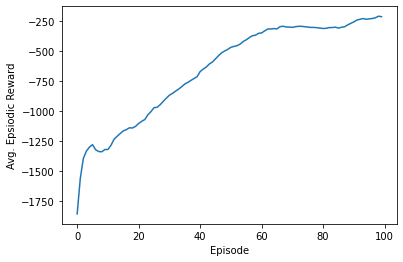

In [5]:
loop_env()

### Exercise (3) LunarLanding

The Lunar Landing exercise is far more challenging then Pendulum-0. In the LudarLander, the Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

For more information, visit https://github.com/openai/gym/wiki/Leaderboard#lunarlander-v2

In [6]:
    from lundar_landing import LunarLanderContinuous
    
    problem = "LunarLanderContinuous-v2"
    env = LunarLanderContinuous()

    num_states = env.observation_space.shape[0]
    print("Size of State Space ->  {}".format(num_states))
    num_actions = env.action_space.shape[0]
    print("Size of Action Space ->  {}".format(num_actions))

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]

    print("Max Value of Action ->  {}".format(upper_bound))
    print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [7]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

In reality, it takes thousands of episodes for DDPG to converge in this environment, just run for 100 episodes and observe the avg reward!

Episode * 0 * Avg Reward is ==> -743.8506289455174
Episode * 1 * Avg Reward is ==> -587.8083928086376
Episode * 2 * Avg Reward is ==> -640.2908270824241
Episode * 3 * Avg Reward is ==> -577.2213522042231
Episode * 4 * Avg Reward is ==> -534.2735031730574
Episode * 5 * Avg Reward is ==> -522.1359629800244
Episode * 6 * Avg Reward is ==> -489.1496566165365
Episode * 7 * Avg Reward is ==> -453.0092767556135
Episode * 8 * Avg Reward is ==> -399.4636760024703
Episode * 9 * Avg Reward is ==> -374.23267292677707
Episode * 10 * Avg Reward is ==> -353.2706438662631
Episode * 11 * Avg Reward is ==> -347.7660730085693
Episode * 12 * Avg Reward is ==> -340.5758952303786
Episode * 13 * Avg Reward is ==> -350.0694902176243
Episode * 14 * Avg Reward is ==> -382.5098352282767
Episode * 15 * Avg Reward is ==> -385.1424928594816
Episode * 16 * Avg Reward is ==> -386.4694492794756
Episode * 17 * Avg Reward is ==> -403.96366300280386
Episode * 18 * Avg Reward is ==> -393.7024135683726
Episode * 19 * Avg R

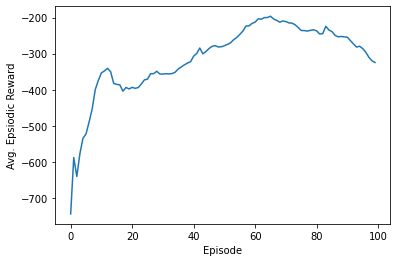

In [8]:
loop_env()

### Exercise (4) SafeLunarLanding

The SafeLunarLanding environment, is an altered version of LundarLander-v2 created for the purpose of this Tutorial. In this version, the main and lateral engines explode when put overpressure for more than 20 timesteps per episode. The spaceship is considered to be overpressured on its engines if one of the following situations is verified:

-(1) Main Engine over 0.7 capacity

-(2) Left Engine less than -0.7 capacity

-(3) Right Engine over 0.7 capacity

In [4]:
    from lundar_landing import LunarLanderContinuous
    from safe_lunar_env import SafeLunarEnv

    problem = "LunarLanderContinuous-v2"
    env = LunarLanderContinuous()
    env = SafeLunarEnv(env)

    num_states = env.observation_space.shape[0]
    print("Size of State Space ->  {}".format(num_states))
    num_actions = env.action_space.shape[0]
    print("Size of Action Space ->  {}".format(num_actions))

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]

    print("Max Value of Action ->  {}".format(upper_bound))
    print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In reality, it takes thousands of episodes for DDPG to converge in this environment, just run for 100 episodes and observe the avg reward!

In [5]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

Episode * 0 * Avg Reward is ==> -1861.8121472558269
Episode * 1 * Avg Reward is ==> -1362.058577768526
Episode * 2 * Avg Reward is ==> -945.9362247435735
Episode * 3 * Avg Reward is ==> -784.9042609326226
Episode * 4 * Avg Reward is ==> -762.3835647852836
Episode * 5 * Avg Reward is ==> -913.6105688855731
Episode * 6 * Avg Reward is ==> -863.213232826799
Episode * 7 * Avg Reward is ==> -852.7276730562224
Episode * 8 * Avg Reward is ==> -773.4116513307007
Episode * 9 * Avg Reward is ==> -723.8668634703929
Episode * 10 * Avg Reward is ==> -797.9243611595049
Episode * 11 * Avg Reward is ==> -763.4123214941542
Episode * 12 * Avg Reward is ==> -713.2745975264769
Episode * 13 * Avg Reward is ==> -691.9872329130095
Episode * 14 * Avg Reward is ==> -744.0335276611072
Episode * 15 * Avg Reward is ==> -730.0105272538141
Episode * 16 * Avg Reward is ==> -701.6199659587795
Episode * 17 * Avg Reward is ==> -683.3515252167575
Episode * 18 * Avg Reward is ==> -663.8712519785835
Episode * 19 * Avg Rew

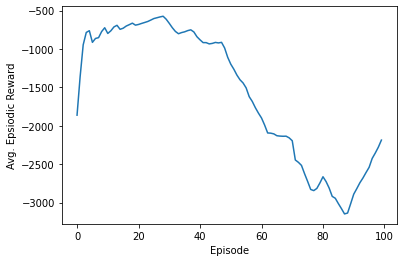

In [6]:
loop_env()

### Exercise (5) Shield for SafeLunarLanding
In this Exercise, you will implement the shield to save the spaceship from exploding! With Exercise 4 in mind, implement the needed action shield and parameters. Then test the agent and verify the yielding of much higher rewards through learning when compared with the version without the shield. Feel free change the paramters to verify its effects!

In [7]:
class Shield:
    def __init__(self,
                 thresholds_main_engine=0.7,
                 thresholds_left_engine=-.7,
                 thresholds_right_engine=.7):
        self.thresholds_main_engine = thresholds_main_engine
        self.thresholds_left_engine = thresholds_left_engine
        self.thresholds_right_engine = thresholds_right_engine

    def shield_action(self, action):

        action_main_engine = np.clip(action[0], -self.thresholds_main_engine,
                                     self.thresholds_main_engine)

        action_lateral_engines = np.clip(action[1],
                                         self.thresholds_left_engine,
                                         self.thresholds_right_engine)

        action = [action_main_engine, action_lateral_engines]
        return action

env = SafeLunarEnv(env, Shield())

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [8]:
 ddpg_agent = DDPG(problem_name=problem,
                      num_states=num_states,
                      num_actions=num_actions,
                      lower_bound=lower_bound,
                      upper_bound=upper_bound,
                      total_episodes=100)

In reality, it takes thousands of episodes for DDPG to converge in this environment, just run for 100 episodes and observe the avg reward!

Episode * 0 * Avg Reward is ==> -124.87690743216586
Episode * 1 * Avg Reward is ==> -303.5677688607878
Episode * 2 * Avg Reward is ==> -342.5541242779546
Episode * 3 * Avg Reward is ==> -318.97395125552373
Episode * 4 * Avg Reward is ==> -294.78257205414695
Episode * 5 * Avg Reward is ==> -276.01949405044274
Episode * 6 * Avg Reward is ==> -260.6615841363757
Episode * 7 * Avg Reward is ==> -245.57375079921982
Episode * 8 * Avg Reward is ==> -232.90096868292025
Episode * 9 * Avg Reward is ==> -216.21813030613103
Episode * 10 * Avg Reward is ==> -216.50056830280425
Episode * 11 * Avg Reward is ==> -218.92142011209194
Episode * 12 * Avg Reward is ==> -208.96754576830503
Episode * 13 * Avg Reward is ==> -201.84709012723923
Episode * 14 * Avg Reward is ==> -197.4417865601381
Episode * 15 * Avg Reward is ==> -194.48724288742858
Episode * 16 * Avg Reward is ==> -189.75644755922374
Episode * 17 * Avg Reward is ==> -185.2604814871778
Episode * 18 * Avg Reward is ==> -181.6599038226522
Episode *

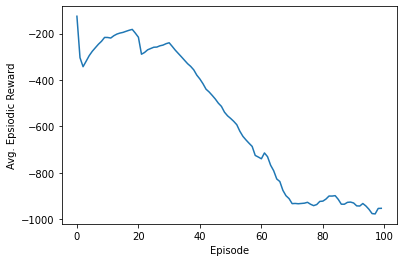

In [9]:
loop_env()